In [1]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from IPython.display import Audio
import IPython.display as ipd
import warnings
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
import math
from keras.utils import np_utils
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.regularizers import l1_l2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
crema_path='/kaggle/input/speech-emotion-recognition-en/Crema'
crema=[]
for wav in os.listdir(crema_path):
    emotion=wav.partition(".wav")[0].split('_')
    if emotion[2]=='SAD':
        crema.append(('Sad',crema_path+'/'+wav))
    elif emotion[2]=='ANG':
        crema.append(('Angry',crema_path+'/'+wav))
    elif emotion[2]=='DIS':
        crema.append(('Disgust',crema_path+'/'+wav))
    elif emotion[2]=='FEA':
        crema.append(('Fear',crema_path+'/'+wav))
    elif emotion[2]=='HAP':
        crema.append(('Happy',crema_path+'/'+wav))
    elif emotion[2]=='NEU':
        crema.append(('Neutral',crema_path+'/'+wav))
    else:
        crema.append(('unknown',crema_path+'/'+wav))
crema_df=pd.DataFrame.from_dict(crema)
crema_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
crema_df.head()

,Emotion,File_Path
0,Disgust,/kaggle/input/speech-emotion-recognition-en/Cr...
1,Happy,/kaggle/input/speech-emotion-recognition-en/Cr...
2,Happy,/kaggle/input/speech-emotion-recognition-en/Cr...
3,Disgust,/kaggle/input/speech-emotion-recognition-en/Cr...
4,Disgust,/kaggle/input/speech-emotion-recognition-en/Cr...


## Augmenting data

In [4]:
audio_arrays = []
for i in crema_df['File_Path']:
    x, sr = librosa.load(i,duration=2)
    l=len(x)
    padding = (44100) - l
    if l > 44100:
        x = x[:44100]
    elif l < 44100:
        x = np.pad(x, (0, padding), mode='constant')
    audio_arrays.append(x)
crema_df['Arrays'] = audio_arrays

## Getting same data as 1D

In [5]:
test_indices=pd.read_csv('/kaggle/input/test-indicess/test_data_indices_without_aug.csv')
train_indices=pd.read_csv('/kaggle/input/train-indicess/train_data_indices_without_aug.csv')
val_indices=pd.read_csv('/kaggle/input/valid-indicess/valid_data_indices_without_aug.csv')
train_list=[int(element) for element in list(np.array(train_indices))]
test_list=[int(element) for element in list(np.array(test_indices))]
val_list=[int(element) for element in list(np.array(val_indices))]
train_data=crema_df.iloc[train_list]
val_data=crema_df.iloc[val_list]
test_data=crema_df.iloc[test_list]

In [6]:
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

In [7]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)


In [8]:
crema_df.head()

,Emotion,File_Path,Arrays
0,Disgust,/kaggle/input/speech-emotion-recognition-en/Cr...,"[0.0051987115, 0.0065078777, 0.0063527757, 0.0..."
1,Happy,/kaggle/input/speech-emotion-recognition-en/Cr...,"[-0.0054751206, -0.0067585437, -0.0058223438, ..."
2,Happy,/kaggle/input/speech-emotion-recognition-en/Cr...,"[-2.10721e-05, 0.00036462393, 0.00048545774, 0..."
3,Disgust,/kaggle/input/speech-emotion-recognition-en/Cr...,"[0.0027296818, 0.0009894323, -0.00012592837, 0..."
4,Disgust,/kaggle/input/speech-emotion-recognition-en/Cr...,"[-0.0012989982, -0.0013569102, -0.0005801881, ..."


In [16]:
from tqdm import tqdm
for i in tqdm(range(4948)):
    data_to_be_augmented=train_data['Arrays'].iloc[i]
    noise_data=noise(data_to_be_augmented)
    pitched_data=pitch(data_to_be_augmented,22050)
    stretched_data=stretch(data_to_be_augmented)
    train_data.loc[len(train_data.index)] = [train_data['Emotion'].iloc[i],train_data['Emotion'].iloc[i],noise_data] 
    train_data.loc[len(train_data.index)] = [train_data['Emotion'].iloc[i],train_data['Emotion'].iloc[i],pitched_data]

100%|██████████| 4948/4948 [04:21<00:00, 18.95it/s]


In [12]:
len(crema_df)

7442

# Use

In [17]:
def get_melspectrogram(data):
    mel_signal = librosa.feature.melspectrogram(y=data, sr=44100)
    spectrogram = np.abs(mel_signal)
    power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
    return power_to_db

In [18]:
len(train_data['Arrays'][1])

44100

In [19]:
train_set_spectorgram = np.zeros((len(train_data),128,87)) # mel spectrogram training 
for i in tqdm(range(len(train_data))):
    train_set_spectorgram[i]= get_melspectrogram(train_data['Arrays'].iloc[i]).T

100%|██████████| 4948/4948 [00:55<00:00, 89.32it/s]


In [20]:
val_set_spectorgram = np.zeros((len(val_data),128,87))  
for i in tqdm(range(len(val_data))):
    val_set_spectorgram[i]= get_melspectrogram(val_data['Arrays'].iloc[i]).T
test_set_spectorgram = np.zeros((len(test_data),128,87)) 
for i in tqdm(range(len(test_data))):
    test_set_spectorgram[i]= get_melspectrogram(test_data['Arrays'].iloc[i]).T

100%|██████████| 2233/2233 [00:25<00:00, 88.24it/s]


In [21]:
import pickle
with open('train_set_spectorgram', 'wb') as trsp:
    pickle.dump(train_set_spectorgram, trsp)
with open('val_set_spectorgram', 'wb') as valsp:
    pickle.dump(val_set_spectorgram, valsp)
with open('test_set_spectorgram', 'wb') as tssp:
    pickle.dump(test_set_spectorgram, tssp)

In [22]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
train_data['Emotion']= label_encoder.fit_transform(train_data['Emotion'])
val_data['Emotion']= label_encoder.fit_transform(val_data['Emotion'])
test_data['Emotion']= label_encoder.fit_transform(test_data['Emotion'])

In [23]:
labels_train = train_data['Emotion'].tolist()
labels_val = val_data['Emotion'].tolist()
labels_test = test_data['Emotion'].tolist()

In [24]:
with open('labels_train', 'wb') as ltr:
    pickle.dump(labels_train, ltr)
with open('labels_val', 'wb') as lval:
    pickle.dump(labels_val, lval)
with open('labels_test', 'wb') as ltst:
    pickle.dump(labels_test, ltst)

In [25]:
import pickle
with open('train_set_spectorgram', 'rb') as trsp:
    train_set_spectorgram = pickle.load(trsp)
with open('val_set_spectorgram', 'rb') as valsp:
    val_set_spectorgram = pickle.load(valsp)
with open('test_set_spectorgram', 'rb') as tssp:
    test_set_spectorgram = pickle.load(tssp)
with open('labels_train', 'rb') as ltr:
    labels_train = pickle.load(ltr)
with open('labels_val', 'rb') as lval:
    labels_val = pickle.load(lval)
with open('labels_test', 'rb') as ltst:
    labels_test = pickle.load(ltst)

In [30]:
import keras

In [35]:
train_set_spectorgram[0].shape

(128, 87)

In [57]:
from skimage.transform import resize

In [58]:
train_set=prepare_spectograms(train_set_spectorgram)

In [59]:
val_set=prepare_spectograms(val_set_spectorgram)

In [60]:
test_set=prepare_spectograms(test_set_spectorgram)

/tmp/ipykernel_31/1648806182.py:12: RuntimeWarning: invalid value encountered in divide
  normalized_spec = (resized_spec - np.mean(resized_spec)) / np.std(resized_spec)


In [49]:
def prepare_spectograms(spectrograms):
    #maximum dimensions
    max_height = max(spec.shape[0] for spec in spectrograms)
    max_width = max(spec.shape[1] for spec in spectrograms)

    processed_spectrograms = []
    for spec in spectrograms:
        #Resize spectrograms
        resized_spec = resize(spec, (max_height, max_width), mode='constant')

        #Normalize spectrograms
        normalized_spec = (resized_spec - np.mean(resized_spec)) / np.std(resized_spec)
        normalized_spec = np.nan_to_num(normalized_spec)

        processed_spectrograms.append(normalized_spec)

    #Stack spectrograms into a single 4D array
    stacked_spectrograms = np.stack(processed_spectrograms, axis=0)
    stacked_spectrograms = stacked_spectrograms[..., np.newaxis]  # Add channel dimension

    return stacked_spectrograms

In [72]:
model1=tf.keras.Sequential([
    L.Conv2D(75,kernel_size=(5,5), activation='relu',input_shape=(128, 87, 1)),
    L.MaxPool2D(),
    
    L.Conv2D(135,kernel_size=(5,5), activation='relu'),
    L.MaxPool2D(),
    
    L.Dropout(0.25),
    
    L.Conv2D(75,kernel_size=(5,5), activation='relu'),
    L.MaxPool2D(),
    
    L.Dropout(0.25),
    
    L.Flatten(),
    
    L.Dense(45,activation='relu'),
    L.Dropout(0.5),
  
    L.Dense(6,activation='softmax'),
])
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 124, 83, 75)       1950      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 62, 41, 75)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 58, 37, 135)       253260    
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 29, 18, 135)      0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 29, 18, 135)       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 25, 14, 75)      

In [77]:
early_stop=EarlyStopping(monitor='val_loss',mode='auto',patience=10,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.1,min_lr=1e-6)
his1 = model1.fit(np.array(train_set),np.array(labels_train), batch_size=64, epochs=200, validation_data= (np.array(val_set), np.array(labels_val)),callbacks=[early_stop,lr_reduction])

Epoch 1/200
78/78 [==============================] - 3s 44ms/step - loss: 0.9380 - accuracy: 0.6368 - val_loss: 1.0939 - val_accuracy: 0.5747 - lr: 1.0000e-06
Epoch 2/200
78/78 [==============================] - 3s 43ms/step - loss: 0.9413 - accuracy: 0.6334 - val_loss: 1.0952 - val_accuracy: 0.5747 - lr: 1.0000e-06
Epoch 3/200
78/78 [==============================] - 3s 42ms/step - loss: 0.9457 - accuracy: 0.6263 - val_loss: 1.0961 - val_accuracy: 0.5709 - lr: 1.0000e-06
Epoch 4/200
78/78 [==============================] - 3s 42ms/step - loss: 0.9437 - accuracy: 0.6346 - val_loss: 1.0967 - val_accuracy: 0.5747 - lr: 1.0000e-06
Epoch 5/200
78/78 [==============================] - 3s 42ms/step - loss: 0.9339 - accuracy: 0.6429 - val_loss: 1.0962 - val_accuracy: 0.5709 - lr: 1.0000e-06
Epoch 6/200
78/78 [==============================] - 3s 42ms/step - loss: 0.9422 - accuracy: 0.6409 - val_loss: 1.0952 - val_accuracy: 0.5709 - lr: 1.0000e-06
Epoch 7/200
78/78 [===========================

In [78]:
y_pred = model1.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
from sklearn.metrics import accuracy_score
accuracy_score(np.array(labels_test), y_pred)*100

70/70 [==============================] - 0s 5ms/step


57.09807433945365

In [79]:
model1.save_weights('conv2D_model.h5')

In [81]:
# Convert to a pandas DataFrame
df2 = pd.DataFrame({'y_pred': y_pred})

# Save as CSV file
df2.to_csv('y_pred.csv', index=False)

In [82]:
model6=tf.keras.Sequential([
    L.Conv2D(32,kernel_size=(3,3), activation='relu',input_shape=(128, 87, 1)),
    L.MaxPool2D((2,2)),
    L.BatchNormalization(),
    L.Conv2D(32,kernel_size=(3,3), activation='relu'),
    L.MaxPool2D((2,2)),
    L.BatchNormalization(),
    L.Conv2D(64,kernel_size=(3,3), activation='relu'),
    L.MaxPool2D((2,2)),
    L.Conv2D(64,kernel_size=(3,3), activation='relu'),
    L.MaxPool2D((2,2)),
    L.Flatten(),
    L.Dense(64,activation='relu'),
    L.Dropout(0.2),
    L.Dense(6,activation='softmax')
])
model6.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model6.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 126, 85, 32)       320       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 63, 42, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Batc  (None, 63, 42, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_37 (Conv2D)          (None, 61, 40, 32)        9248      
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 30, 20, 32)       0         
 g2D)                                                            
                                                     

In [83]:
stop=EarlyStopping(monitor='val_loss',mode='auto',patience=7,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.1,min_lr=1e-6)
his6 = model6.fit(np.array(train_set_spectorgram),np.array(labels_train), batch_size=64, epochs=100, validation_data= (np.array(val_set_spectorgram), np.array(labels_val)),callbacks=[early_stop,lr_reduction])

Epoch 1/100
78/78 [==============================] - 2s 15ms/step - loss: 1.7778 - accuracy: 0.2516 - val_loss: 2.8067 - val_accuracy: 0.1686 - lr: 1.0000e-04
Epoch 2/100
78/78 [==============================] - 1s 12ms/step - loss: 1.5278 - accuracy: 0.3640 - val_loss: 1.8895 - val_accuracy: 0.2031 - lr: 1.0000e-04
Epoch 3/100
78/78 [==============================] - 1s 13ms/step - loss: 1.4524 - accuracy: 0.4089 - val_loss: 1.5375 - val_accuracy: 0.3602 - lr: 1.0000e-04
Epoch 4/100
78/78 [==============================] - 1s 12ms/step - loss: 1.4110 - accuracy: 0.4297 - val_loss: 1.5001 - val_accuracy: 0.4215 - lr: 1.0000e-04
Epoch 5/100
78/78 [==============================] - 1s 11ms/step - loss: 1.3772 - accuracy: 0.4499 - val_loss: 1.4678 - val_accuracy: 0.4444 - lr: 1.0000e-04
Epoch 6/100
78/78 [==============================] - 1s 12ms/step - loss: 1.3482 - accuracy: 0.4695 - val_loss: 1.4391 - val_accuracy: 0.4368 - lr: 1.0000e-04
Epoch 7/100
78/78 [===========================

In [84]:
y_pred = model6.predict(test_set_spectorgram)
y_pred = np.argmax(y_pred, axis=1)
from sklearn.metrics import accuracy_score
accuracy_score(np.array(labels_test), y_pred)*100

70/70 [==============================] - 0s 3ms/step


51.05239587998208

## Model 1 is better

# - Comparing 1D Vs 2D 

## Loading 1D and 2D predictions

In [2]:
y_pred_1d=pd.read_csv('/kaggle/input/y-pred-1d/1D_Model_Predictions.csv')
y_pred_2d=pd.read_csv('/kaggle/input/y-pred-2d/y_pred.csv')
y_pred_1d=np.array(y_pred_1d)
y_pred_2d=np.array(y_pred_2d)

In [6]:
labels_test=pd.read_csv('/kaggle/input/labels-test/labels_test.csv')
labels_test=np.array(labels_test)

In [8]:
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report

# 1st : Accuracy

In [7]:
accuracy_1d=accuracy_score(labels_test, y_pred_1d)*100
accuracy_2d=accuracy_score(labels_test, y_pred_2d)*100
print("1D Accuracy = "+str(accuracy_1d))
print("2D Accuracy = "+str(accuracy_2d))

1D Accuracy = 53.64979847738468
2D Accuracy = 57.09807433945365


## It is noticed that 2D accuracy is higher on the same audios , this is due to that conv2D has extracted more features in the neural network from the spectrogram , which contains more data of the soundtrack than 1D model features

# 2nd : F1-Score

In [32]:
emotion_map={0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad'}

In [15]:
target_labels=['Angry','Disgust','Fear','Happy','Neutral','Sad']

In [16]:
print(f'1D Model Classification Report\n',classification_report(labels_test,y_pred_1d,target_names=target_labels))

1D Model Classification Report
               precision    recall  f1-score   support

       Angry       0.55      0.87      0.68       382
     Disgust       0.37      0.52      0.44       381
        Fear       0.55      0.39      0.46       381
       Happy       0.74      0.42      0.53       382
     Neutral       0.57      0.48      0.52       326
         Sad       0.60      0.51      0.55       381

    accuracy                           0.54      2233
   macro avg       0.56      0.54      0.53      2233
weighted avg       0.56      0.54      0.53      2233



In [18]:
print(f'2D Model Classification Report\n',classification_report(labels_test,y_pred_2d,target_names=target_labels))

2D Model Classification Report
               precision    recall  f1-score   support

       Angry       0.67      0.72      0.69       382
     Disgust       0.53      0.46      0.49       381
        Fear       0.52      0.37      0.43       381
       Happy       0.58      0.58      0.58       382
     Neutral       0.57      0.65      0.61       326
         Sad       0.55      0.66      0.60       381

    accuracy                           0.57      2233
   macro avg       0.57      0.57      0.57      2233
weighted avg       0.57      0.57      0.57      2233



## F1 Score is better in 2D Model except for the fear label

# 3rd : Confusion Matrix

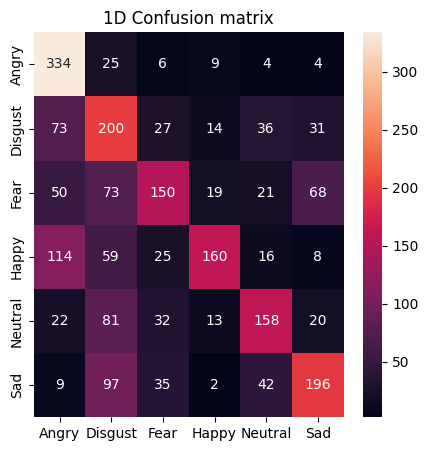

In [36]:
conf1=confusion_matrix(labels_test,y_pred_1d)
cm=pd.DataFrame(conf1,index=[i for i in target_labels],columns=[i for i in target_labels])
plt.figure(figsize=(5,5))
ax=sns.heatmap(cm,annot=True,fmt='d')
ax.set_title(f'1D Confusion matrix')
plt.show()

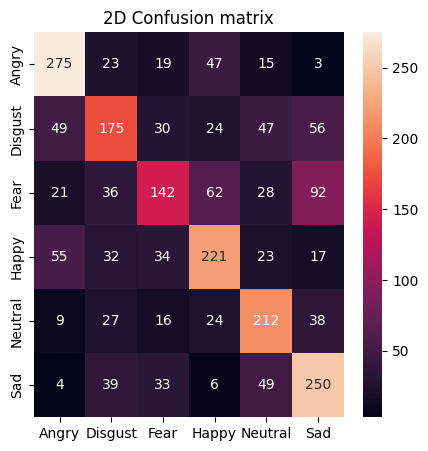

In [28]:
conf2=confusion_matrix(labels_test,y_pred_2d)
cm=pd.DataFrame(conf2,index=[i for i in target_labels],columns=[i for i in target_labels])
plt.figure(figsize=(5,5))
ax=sns.heatmap(cm,annot=True,fmt='d')
ax.set_title(f'2D Confusion matrix')
plt.show()

In [22]:
def extract_most_confusing_classes(confusion_matrix):
    # Compute misclassification rate for each class
    misclassification_rates = np.zeros(confusion_matrix.shape[0])
    for i in range(confusion_matrix.shape[0]):
        total_samples = np.sum(confusion_matrix[i, :])
        misclassified_samples = total_samples - confusion_matrix[i, i]
        misclassification_rates[i] = misclassified_samples / total_samples

    # Sort classes based on misclassification rates in descending order
    sorted_indices = np.argsort(misclassification_rates)[::-1]

    # Sort misclassification rates in descending order
    sorted_rates = misclassification_rates[sorted_indices]

    return sorted_indices, sorted_rates

In [30]:
indices1,con1=extract_most_confusing_classes(conf1)
indices2,con2=extract_most_confusing_classes(conf2)

In [33]:
for idx, rate in zip(indices1, con1):
    print("Class", emotion_map[idx], "- Confusion Rate:", rate)

Class Fear - Confusion Rate: 0.6062992125984252
Class Happy - Confusion Rate: 0.581151832460733
Class Neutral - Confusion Rate: 0.5153374233128835
Class Sad - Confusion Rate: 0.48556430446194226
Class Disgust - Confusion Rate: 0.47506561679790027
Class Angry - Confusion Rate: 0.1256544502617801


In [34]:
for idx, rate in zip(indices2, con2):
    print("Class", emotion_map[idx], "- Confusion Rate:", rate)

Class Fear - Confusion Rate: 0.6272965879265092
Class Disgust - Confusion Rate: 0.5406824146981627
Class Happy - Confusion Rate: 0.4214659685863874
Class Neutral - Confusion Rate: 0.3496932515337423
Class Sad - Confusion Rate: 0.3438320209973753
Class Angry - Confusion Rate: 0.2801047120418848


## It's noticed that Fear is the most confusing class